<a href="https://colab.research.google.com/github/gregorylira/Diffusion-models/blob/main/class_conditioned_diffusion_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Class-Conditioned Diffusion Model


## Setup and Data Prep

In [ ]:
%pip install -q diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 38.3 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Using device: cuda


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:11<00:00, 896251.57it/s] 


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 134382.44it/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:02<00:00, 752705.27it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4147731.06it/s]


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([7, 3, 7, 6, 0, 5, 8, 5])


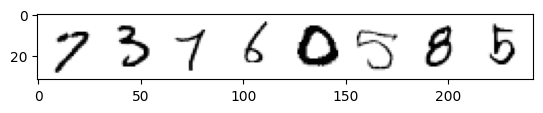

In [ ]:
# Load the dataset
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

# Feed it into a dataloader (batch size 8 here just for demo)
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# View some examples
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

## Creating a Class-Conditioned UNet

In [ ]:
class ClassConditionedUnet(nn.Module):
  def __init__(self, num_classes=10, class_emb_size=4):
    super().__init__()

    # The embedding layer will map the class label to a vector of size class_emb_size
    self.class_emb = nn.Embedding(num_classes, class_emb_size)

    # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
        sample_size=28,           # the target image resolution
        in_channels=1 + class_emb_size, # Additional input channels for class cond.
        out_channels=1,           # the number of output channels
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(32, 64, 64),
        down_block_types=(
            "DownBlock2D",        # a regular ResNet downsampling block
            "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ),
        up_block_types=(
            "AttnUpBlock2D",
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    )

  # Our forward method now takes the class labels as an additional argument
  def forward(self, x, t, class_labels):
    # Shape of x:
    bs, ch, w, h = x.shape

    # class conditioning in right shape to add as additional input channels
    class_cond = self.class_emb(class_labels) # Map to embedding dimension
    class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
    # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)

    # Net input is now x and class cond concatenated together along dimension 1
    net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)

    # Feed this to the UNet alongside the timestep and return the prediction
    return self.model(net_input, t).sample # (bs, 1, 28, 28)

If any of the shapes or transforms are confusing, add in print statements to show the relevant shapes and check that they match your expectations. I've also annotated the shapes of some intermediate variables in the hopes of making things clearer.

## Training and Sampling



In [ ]:
# Create a scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 0. Average of the last 100 loss values: 0.053837


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 1. Average of the last 100 loss values: 0.047313


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 2. Average of the last 100 loss values: 0.044507


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 3. Average of the last 100 loss values: 0.042606


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 4. Average of the last 100 loss values: 0.041906


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 5. Average of the last 100 loss values: 0.040532


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 6. Average of the last 100 loss values: 0.039789


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 7. Average of the last 100 loss values: 0.039140


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 8. Average of the last 100 loss values: 0.040145


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 9. Average of the last 100 loss values: 0.039273


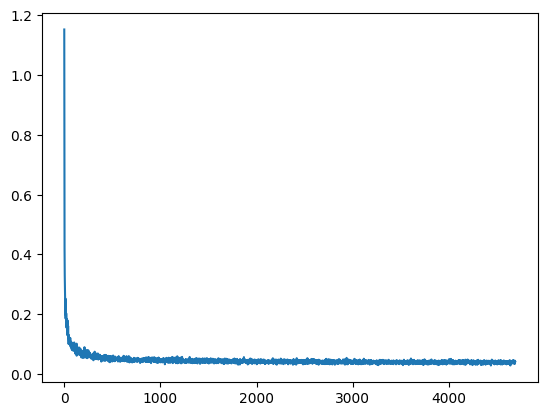

In [ ]:
# Redefining the dataloader to set the batch size higher than the demo of 8
train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# How many runs through the data should we do?
n_epochs = 10

# Our network
net = ClassConditionedUnet().to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):

        # Get some data and prepare the corrupted version
        x = x.to(device) * 2 - 1 # Data on the GPU (mapped to (-1, 1))
        y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # Get the model prediction
        pred = net(noisy_x, timesteps, y) # Note that we pass in the labels y

        # Calculate the loss
        loss = loss_fn(pred, noise) # How close is the output to the noise

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print out the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:])/100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)

0it [00:00, ?it/s]

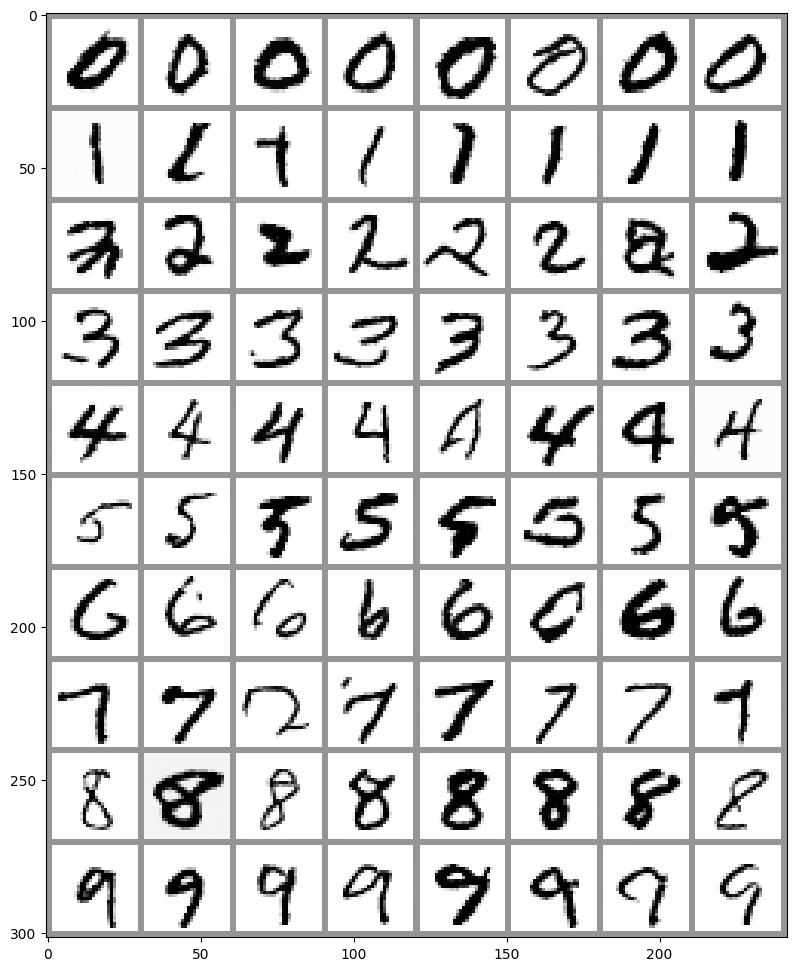

In [ ]:
# Prepare random x to start from, plus some desired labels y
x = torch.randn(80, 1, 28, 28).to(device)
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)

# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    # Get model pred
    with torch.no_grad():
        residual = net(x, t, y)  # Again, note that we pass in our labels y

    # Update sample with step
    x = noise_scheduler.step(residual, t, x).prev_sample

# Show the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap='Greys')

In [ ]:
# todo: Try this with FashionMNIST. Tweak the learning rate, batch size and number of epochs.
# Can you get some decent-looking fashion images with less training time than the example above?

100%|██████████| 26421880/26421880 [00:02<00:00, 12060688.48it/s]


Extracting mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to mnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 190974.88it/s]


Extracting mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to mnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:06<00:00, 663843.69it/s] 


Extracting mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to mnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5881851.54it/s]


Extracting mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/FashionMNIST/raw

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([1, 5, 6, 6, 9, 9, 9, 0])


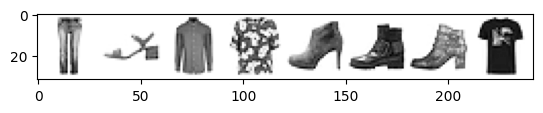

In [ ]:
dataset = torchvision.datasets.FashionMNIST(root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor())

train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

In [ ]:
len(dataset.classes)

10

In [ ]:
class ClassConditionedUnetFashionMNIST(nn.Module):
  def __init__(self, num_classes=10, class_emb_size=4):
    super().__init__()

    # The embedding layer will map the class label to a vector of size class_emb_size
    self.class_emb = nn.Embedding(num_classes, class_emb_size)

    # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
        sample_size=28,           # the target image resolution
        in_channels=1 + class_emb_size, # Additional input channels for class cond.
        out_channels=1,           # the number of output channels
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(32, 64, 64),
        down_block_types=(
            "DownBlock2D",        # a regular ResNet downsampling block
            "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ),
        up_block_types=(
            "AttnUpBlock2D",
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    )

  # Our forward method now takes the class labels as an additional argument
  def forward(self, x, t, class_labels):
    # Shape of x:
    bs, ch, w, h = x.shape

    # class conditioning in right shape to add as additional input channels
    class_cond = self.class_emb(class_labels) # Map to embedding dimension
    class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
    # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)

    # Net input is now x and class cond concatenated together along dimension 1
    net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)

    # Feed this to the UNet alongside the timestep and return the prediction
    return self.model(net_input, t).sample # (bs, 1, 28, 28)

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

  0%|          | 0/938 [00:00<?, ?it/s]

Finished epoch 0. Average of the last 100 loss values: 0.053354


  0%|          | 0/938 [00:00<?, ?it/s]

Finished epoch 1. Average of the last 100 loss values: 0.047072


  0%|          | 0/938 [00:00<?, ?it/s]

Finished epoch 2. Average of the last 100 loss values: 0.045853


  0%|          | 0/938 [00:00<?, ?it/s]

Finished epoch 3. Average of the last 100 loss values: 0.044858


  0%|          | 0/938 [00:00<?, ?it/s]

Finished epoch 4. Average of the last 100 loss values: 0.041597


  0%|          | 0/938 [00:00<?, ?it/s]

Finished epoch 5. Average of the last 100 loss values: 0.043787


  0%|          | 0/938 [00:00<?, ?it/s]

Finished epoch 6. Average of the last 100 loss values: 0.040978


  0%|          | 0/938 [00:00<?, ?it/s]

Finished epoch 7. Average of the last 100 loss values: 0.041575


  0%|          | 0/938 [00:00<?, ?it/s]

Finished epoch 8. Average of the last 100 loss values: 0.040287


  0%|          | 0/938 [00:00<?, ?it/s]

Finished epoch 9. Average of the last 100 loss values: 0.041009


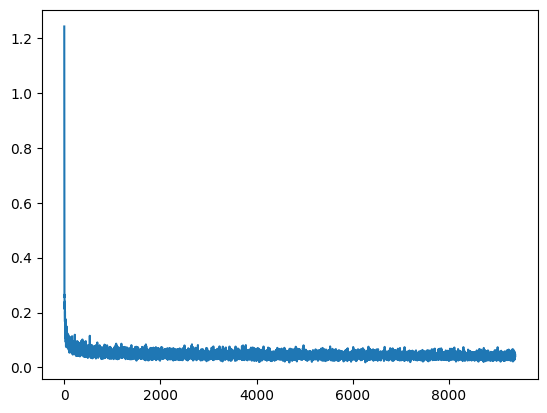

In [ ]:
bs = 64
n_epochs = 10
train_dataloader = DataLoader(dataset, batch_size=bs, shuffle=True)

loss_fn = nn.MSELoss()
net = ClassConditionedUnetFashionMNIST().to(device)
losses = []
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

for epoch in range(n_epochs):
  for x, y in tqdm(train_dataloader):
    x = x.to(device)
    y = y.to(device)
    noise = torch.randn_like(x)
    timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
    noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

    pred = net(noisy_x, timesteps, y)
    loss = loss_fn(pred, noise)

    opt.zero_grad()
    loss.backward()
    opt.step()
    losses.append(loss.item())

  avg_loss = sum(losses[-100:])/100
  print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

plt.plot(losses)



0it [00:00, ?it/s]

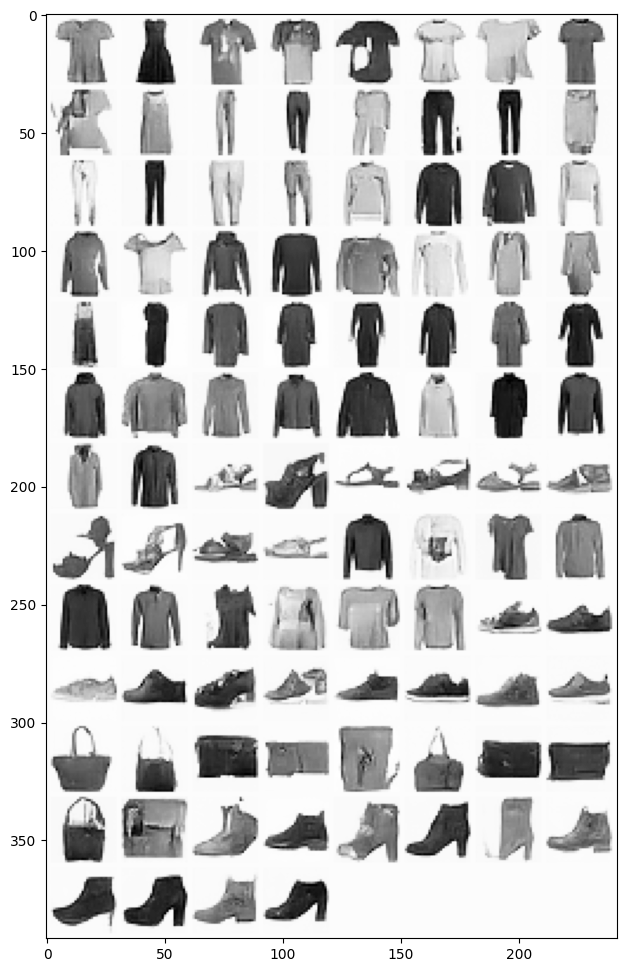

In [ ]:
x = torch.randn(100, 1, 28, 28).to(device)
y = torch.tensor([[i]*10 for i in range(10)]).flatten().to(device)

for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
  with torch.no_grad():
    residual = net(x, t, y)

  x = noise_scheduler.step(residual, t, x).prev_sample

# Show the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap='Greys')

0it [00:00, ?it/s]

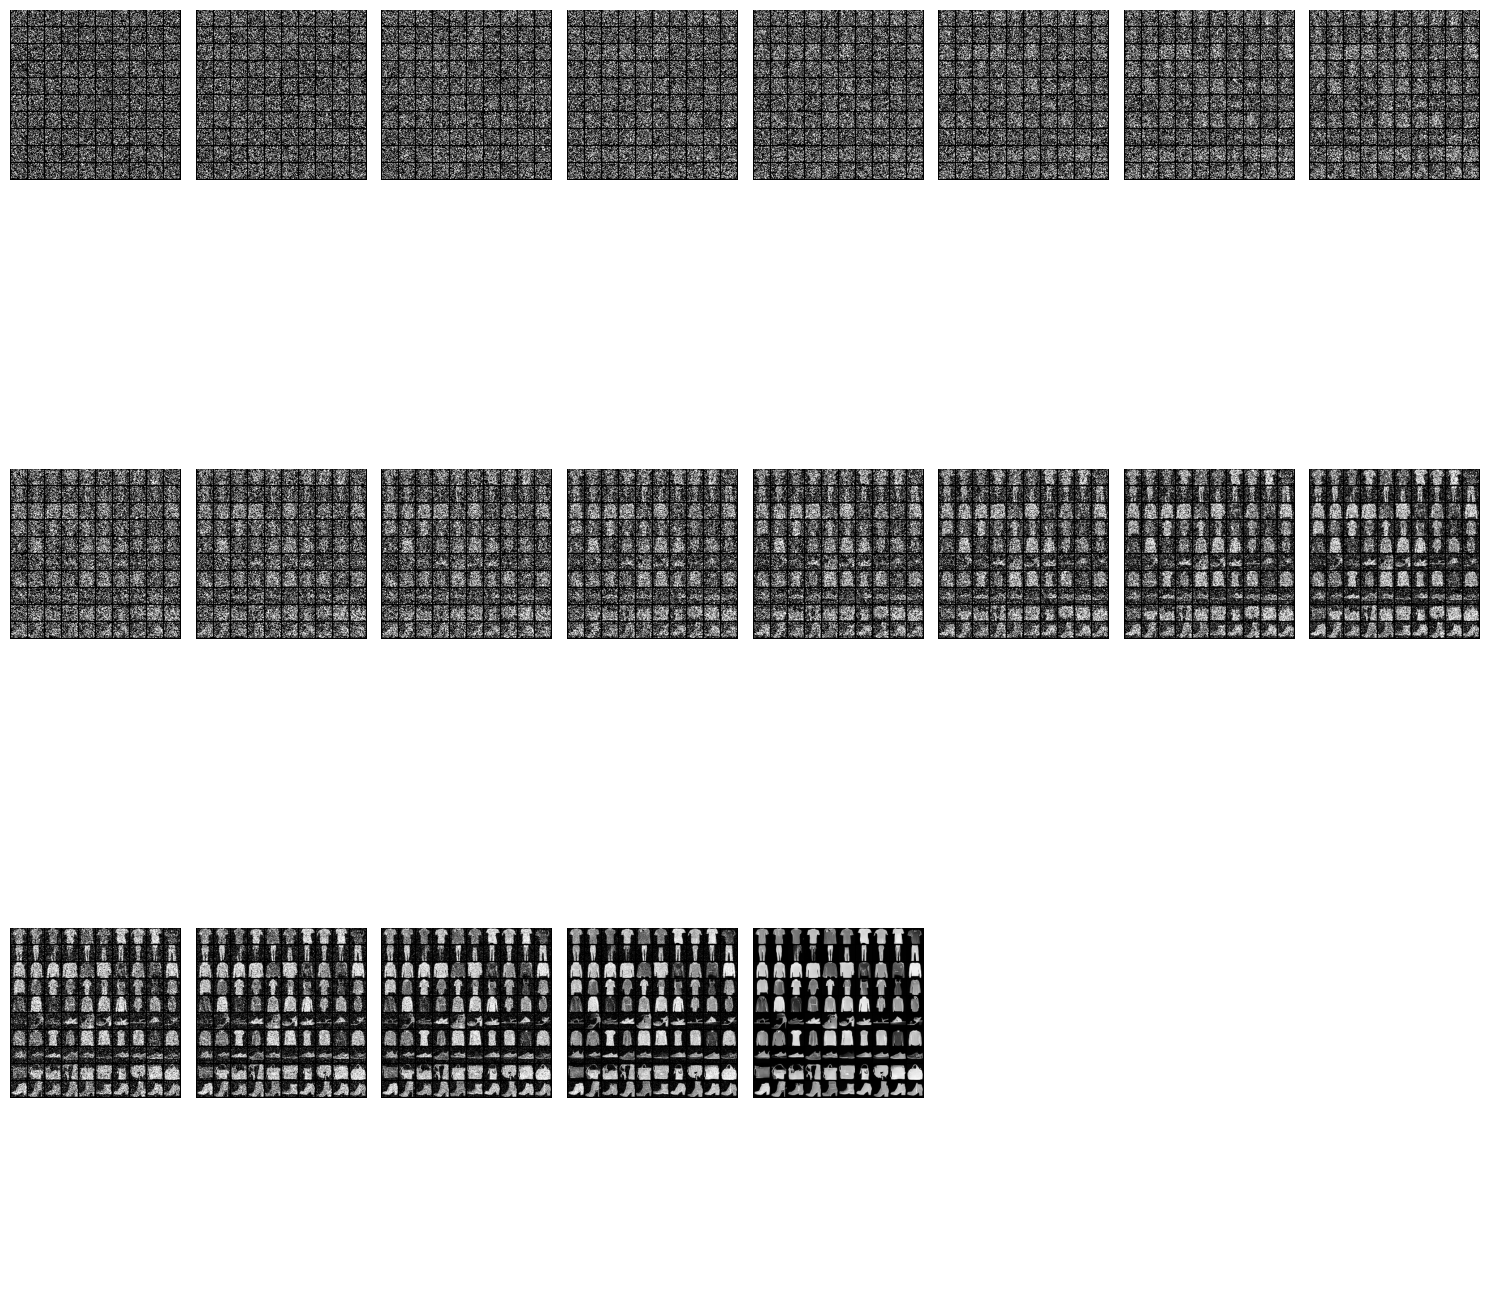

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt

x = torch.randn(100, 1, 28, 28).to(device)
y = torch.tensor([[i] * 10 for i in range(10)]).flatten().to(device)

images = []

for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    with torch.no_grad():
        residual = net(x, t, y)

    x = noise_scheduler.step(residual, t, x).prev_sample

    if i % 50 == 0 or i == len(noise_scheduler.timesteps) - 1:
        images.append(x.detach().cpu().clone())

num_images = len(images)
num_cols = 8  # Número de colunas
num_rows = (num_images + num_cols - 1) // num_cols  # Calcula o número de linhas necessário

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
axes = axes.flatten()  # Facilita a iteração

for idx, img in enumerate(images):
    # Ajusta o grid para 10 colunas
    axes[idx].imshow(torchvision.utils.make_grid(img.clip(-1, 1), nrow=10).permute(1, 2, 0), cmap='Greys')
    axes[idx].axis('off')

# Remove eixos extras se houver menos imagens que o número de subplots
for idx in range(num_images, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import os

# Diretório para salvar as imagens
output_dir = "timesteps_images"
os.makedirs(output_dir, exist_ok=True)

# Gera entradas aleatórias e rótulos
x = torch.randn(100, 1, 28, 28).to(device)
y = torch.tensor([[i] * 10 for i in range(10)]).flatten().to(device)

# Loop sobre os timesteps e salva o estado de `x` periodicamente
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    with torch.no_grad():
        residual = net(x, t, y)

    # Atualiza o `x`
    x = noise_scheduler.step(residual, t, x).prev_sample

    # Salva o estado de `x` a cada 50 etapas
    if i % 50 == 0 or i == len(noise_scheduler.timesteps) - 1:
        # Define o nome do arquivo
        filename = os.path.join(output_dir, f"step_{i}.png")

        # Cria a grid das imagens
        grid_img = torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=10)

        # Salva a imagem
        plt.figure(figsize=(12, 12))
        plt.imshow(grid_img.permute(1, 2, 0), cmap='Greys')
        plt.axis('off')
        plt.savefig(filename, bbox_inches='tight', pad_inches=0)
        plt.close()


0it [00:00, ?it/s]

In [ ]:
!zip -r timesteps_images.zip timesteps_images

  adding: timesteps_images/ (stored 0%)
  adding: timesteps_images/step_850.png (deflated 7%)
  adding: timesteps_images/step_800.png (deflated 7%)
  adding: timesteps_images/step_400.png (deflated 9%)
  adding: timesteps_images/step_600.png (deflated 8%)
  adding: timesteps_images/step_50.png (deflated 8%)
  adding: timesteps_images/step_350.png (deflated 9%)
  adding: timesteps_images/step_150.png (deflated 7%)
  adding: timesteps_images/step_250.png (deflated 7%)
  adding: timesteps_images/step_300.png (deflated 8%)
  adding: timesteps_images/step_700.png (deflated 7%)
  adding: timesteps_images/step_200.png (deflated 8%)
  adding: timesteps_images/step_100.png (deflated 7%)
  adding: timesteps_images/step_650.png (deflated 8%)
  adding: timesteps_images/step_500.png (deflated 8%)
  adding: timesteps_images/step_900.png (deflated 7%)
  adding: timesteps_images/step_999.png (deflated 8%)
  adding: timesteps_images/step_450.png (deflated 9%)
  adding: timesteps_images/step_750.png (de

100%|██████████| 170498071/170498071 [00:04<00:00, 42354627.55it/s]


Extracting cifar/cifar-10-python.tar.gz to cifar/
Input shape: torch.Size([8, 3, 32, 32])
Labels: tensor([2, 6, 3, 8, 3, 2, 7, 4])


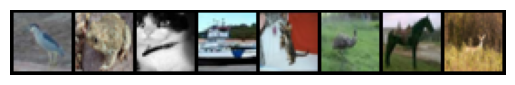

In [ ]:
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),  # Converte as imagens para tensor e normaliza para [0, 1]
])

dataset = torchvision.datasets.CIFAR10(root="cifar/", train=True, download=True, transform=transform)

train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

x, y = next(iter(train_dataloader))

print('Input shape:', x.shape)
print('Labels:', y)

grid_img = torchvision.utils.make_grid(x)

grid_img = grid_img.permute(1, 2, 0).numpy()
# grid_img = (grid_img - grid_img.min()) / (grid_img.max() - grid_img.min())  # Ajusta o intervalo para [0, 1]

plt.imshow(grid_img)
plt.axis('off')  # Oculta os eixos
plt.show()


In [ ]:
len(dataset.classes)

10

In [ ]:
class ClassConditionedUnetCifar10(nn.Module):
  def __init__(self, num_classes=10, class_emb_size=4):
    super().__init__()

    # The embedding layer will map the class label to a vector of size class_emb_size
    self.class_emb = nn.Embedding(num_classes, class_emb_size)

    # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
        sample_size=32,           # the target image resolution
        in_channels=3 + class_emb_size, # Additional input channels for class cond.
        out_channels=3,           # the number of output channels
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(64, 128, 256),
        down_block_types=(
            "DownBlock2D",        # a regular ResNet downsampling block
            "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ),
        up_block_types=(
            "AttnUpBlock2D",
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    )

  # Our forward method now takes the class labels as an additional argument
  def forward(self, x, t, class_labels):
    # Shape of x:
    bs, ch, w, h = x.shape

    # class conditioning in right shape to add as additional input channels
    class_cond = self.class_emb(class_labels) # Map to embedding dimension
    class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
    # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)

    # Net input is now x and class cond concatenated together along dimension 1
    net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)

    # Feed this to the UNet alongside the timestep and return the prediction
    return self.model(net_input, t).sample # (bs, 1, 28, 28)

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

In [ ]:
def show_image(image_tensor, title=""):
    if image_tensor.dim() == 4:  # Tensor de forma (batch_size, channels, height, width)
        image_tensor = image_tensor[0]  # Pegue a primeira imagem do batch
    elif image_tensor.dim() != 3:
        raise ValueError(f"Unexpected number of dimensions: {image_tensor.dim()}")

    image = image_tensor.permute(1, 2, 0).clamp(0, 1).cpu().numpy()
    plt.imshow(image)
    plt.axis('off')
    plt.title(title)
    plt.show()


  0%|          | 0/782 [00:00<?, ?it/s]

Finished epoch 0. Average of the last 100 loss values: 0.041436
tensor(-3.5558, device='cuda:0') tensor(3.9740, device='cuda:0')
tensor(-3.5558, device='cuda:0') tensor(3.9740, device='cuda:0')


0it [00:00, ?it/s]

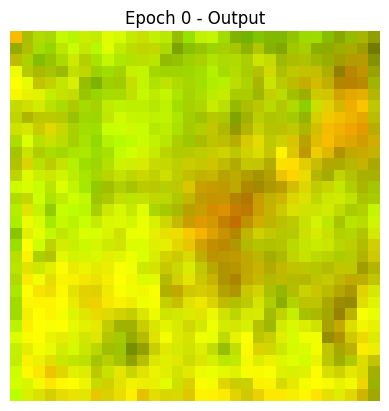

  0%|          | 0/782 [00:00<?, ?it/s]

Finished epoch 1. Average of the last 100 loss values: 0.038281
tensor(-3.3452, device='cuda:0') tensor(3.3091, device='cuda:0')
tensor(-3.3452, device='cuda:0') tensor(3.3091, device='cuda:0')


0it [00:00, ?it/s]

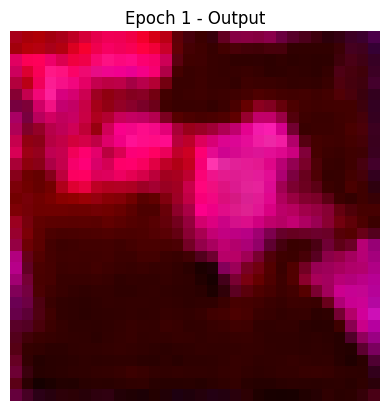

  0%|          | 0/782 [00:00<?, ?it/s]

Finished epoch 2. Average of the last 100 loss values: 0.037778
tensor(-3.4625, device='cuda:0') tensor(3.6896, device='cuda:0')
tensor(-3.4625, device='cuda:0') tensor(3.6896, device='cuda:0')


0it [00:00, ?it/s]

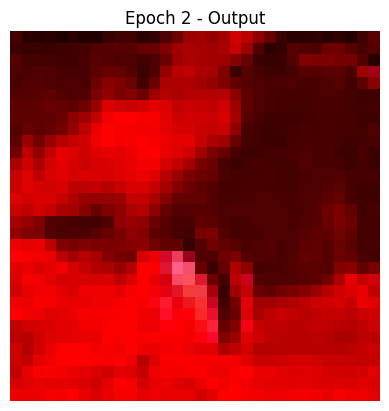

  0%|          | 0/782 [00:00<?, ?it/s]

Finished epoch 3. Average of the last 100 loss values: 0.037113
tensor(-3.3960, device='cuda:0') tensor(3.1619, device='cuda:0')
tensor(-3.3960, device='cuda:0') tensor(3.1619, device='cuda:0')


0it [00:00, ?it/s]

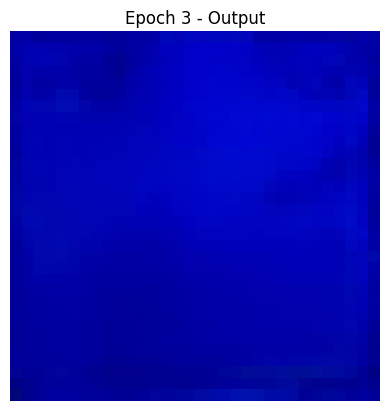

  0%|          | 0/782 [00:00<?, ?it/s]

Finished epoch 4. Average of the last 100 loss values: 0.036025
tensor(-3.8677, device='cuda:0') tensor(3.5667, device='cuda:0')
tensor(-3.8677, device='cuda:0') tensor(3.5667, device='cuda:0')


0it [00:00, ?it/s]

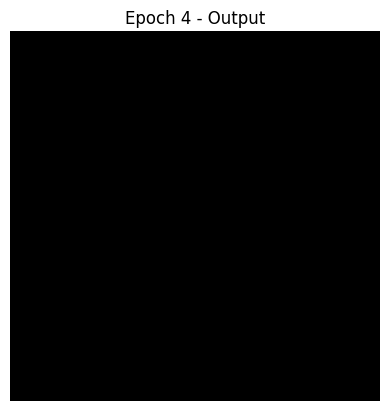

  0%|          | 0/782 [00:00<?, ?it/s]

Finished epoch 5. Average of the last 100 loss values: 0.037287
tensor(-3.3986, device='cuda:0') tensor(3.1607, device='cuda:0')
tensor(-3.3986, device='cuda:0') tensor(3.1607, device='cuda:0')


0it [00:00, ?it/s]

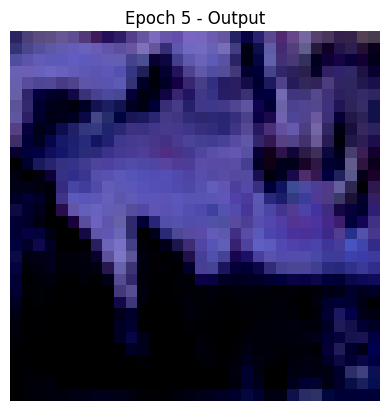

  0%|          | 0/782 [00:00<?, ?it/s]

Finished epoch 6. Average of the last 100 loss values: 0.035967
tensor(-3.2210, device='cuda:0') tensor(3.1578, device='cuda:0')
tensor(-3.2210, device='cuda:0') tensor(3.1578, device='cuda:0')


0it [00:00, ?it/s]

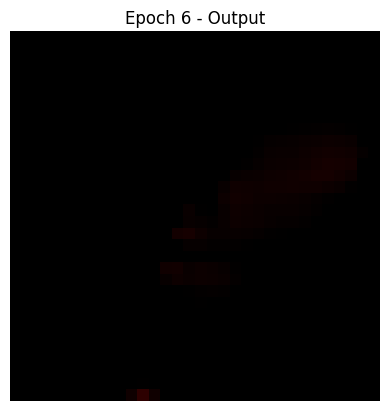

  0%|          | 0/782 [00:00<?, ?it/s]

Finished epoch 7. Average of the last 100 loss values: 0.036781
tensor(-4.1683, device='cuda:0') tensor(3.7228, device='cuda:0')
tensor(-4.1683, device='cuda:0') tensor(3.7228, device='cuda:0')


0it [00:00, ?it/s]

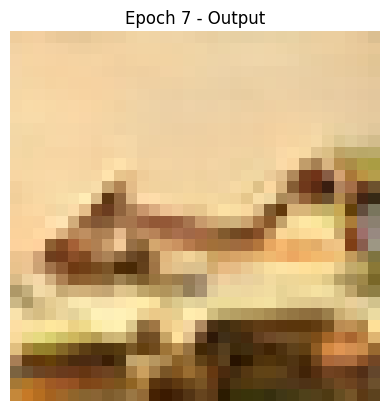

  0%|          | 0/782 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
bs = 64
n_epochs = 50
train_dataloader = DataLoader(dataset, batch_size=bs, shuffle=True)

loss_fn = nn.MSELoss()
net = ClassConditionedUnetCifar10().to(device)
losses = []
opt = torch.optim.Adam(net.parameters(), lr=1e-3)




for epoch in range(n_epochs):
  for x, y in tqdm(train_dataloader):
    x = x.to(device)
    y = y.to(device)

    noise = torch.randn_like(x)
    timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
    noisy_x = noise_scheduler.add_noise(x, noise, timesteps)
    pred = net(noisy_x, timesteps, y)
    loss = loss_fn(pred, noise)

    opt.zero_grad()
    loss.backward()
    opt.step()
    losses.append(loss.item())

  avg_loss = sum(losses[-100:])/100
  print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')


  with torch.no_grad():
    x = torch.randn(1, 3, 32, 32).to(device)
    # x = (x - x.min()) / (x.max() - x.min())  # Normaliza para [0, 1]
    print(x.min(),x.max())
    y = torch.tensor([1]).flatten().to(device)


    print(x.min(), x.max())

    for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
      with torch.no_grad():
        residual = net(x, t, y)

      x = noise_scheduler.step(residual, t, x).prev_sample

    show_image(x[0], title=f'Epoch {epoch} - Output')

plt.plot(losses)


0it [00:00, ?it/s]

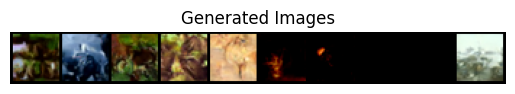

In [ ]:
x = torch.randn(10, 3, 32, 32).to(device)
x = (x - x.min()) / (x.max() - x.min())  # Normaliza para [0, 1]

y = torch.tensor([[i] * 1 for i in range(10)]).flatten().to(device)

# Geração de imagens
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    with torch.no_grad():
        residual = net(x, t, y)

    x = noise_scheduler.step(residual, t, x).prev_sample

def show_image(tensor, title=None):
    image = tensor.cpu().detach()
    image = torchvision.utils.make_grid(image, nrow=10)
    image = image.permute(1, 2, 0).clamp([0,1]).numpy()  # Ajusta o intervalo para [0, 1]
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

show_image(x, title='Generated Images')


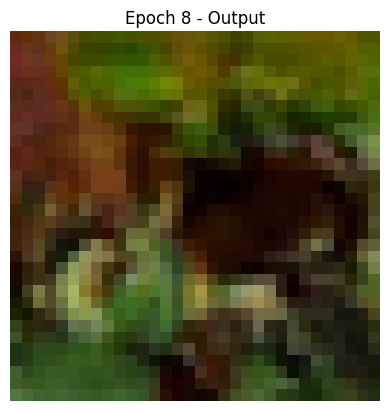

In [ ]:
show_image(x[2], title=f'Epoch {epoch} - Output')

0it [00:00, ?it/s]

Image stats - min: -1.0, max: 1.0


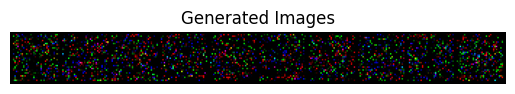

torch.Size([10, 3, 32, 32])

In [ ]:
x = torch.randn(10, 3, 32, 32).to(device)
x = (x - x.min()) / (x.max() - x.min())  # Normaliza para [0, 1]
y = torch.tensor([[i] * 1 for i in range(10)]).flatten().to(device)

for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
  with torch.no_grad():
    residual = net(x, t, y)

  x = noise_scheduler.step(residual, t, x).prev_sample

def show_image(tensor, title=None):
    image = tensor.cpu().detach()
    image = torchvision.utils.make_grid(image, nrow=10)
    # Verifique os valores máximos e mínimos da imagem antes da normalização
    print(f"Image stats - min: {image.min()}, max: {image.max()}")
    image = image.permute(1, 2, 0).clamp(0, 1).numpy()  # Ajusta o intervalo
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()


show_image(x, title='Generated Images')

x.shape
